# Проект 

### План проекта 
[**Шаг 0. Импорт библиотек, методы**](#step_00)

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ**](#step_03)

[**Шаг 4. Объединение таблиц**](#step_04)

[**Шаг 5. Корреляционный анализ**](#step_05)

[**Шаг 6. Использование пайплайнов**](#step_06)

[**Шаг 7. Анализ важности признаков**](#step_07)

[**Шаг 8. Сегментация покупателей**](#step_08)

[**Шаг 9. Вывод**](#step_09)

# Методы 

<a id="step_00"></a>

In [1]:
#импорт нужных библиотек
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from scipy.stats import shapiro
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import QuantileTransformer


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


RANDOM_STATE = 42

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [3]:
def create_histogram(data, column):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [4]:
def create_barplot(data, column, rotation=45):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=rotation)
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']

    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [5]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [6]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [7]:
def scatter_dataframe(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    parameters = []
    for i in num_cols:
        for j in num_cols:
            if (i != j) and (i != 'id') and (j != 'id'):
                if ((i, j) not in parameters) and ((j, i) not in parameters):
                    df.plot(x=i, y=j, kind='scatter')
                    k = i, j
                    parameters.append(k)
    None

In [8]:
def create_boxplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, которая будет отображена на оси x.
    
    Output:
    None
    
    Description:
    Функция создает график ящика с усами на основе указанных столбцов.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)
    plt.show()

# Этап 1. Загрузка данных

In [9]:
try:
    df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
except Exception:
    print('Упc, кажется такого файла нет')

In [10]:
df_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [11]:
df_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [12]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [13]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [14]:
df_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [15]:
df_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


# Этап 2 

In [16]:
data_frames = [df_test_target_job_satisfaction_rate, df_test_features, df_train_job_satisfaction_rate]

for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_test_target_job_satisfaction_rate: 0
Количество дубликатов в датафрейме df_test_features: 0
Количество дубликатов в датафрейме df_train_job_satisfaction_rate: 0


In [17]:
num_col_train_job, cat_col_train_job = cat_num_col(df_train_job_satisfaction_rate)
num_col_test_features, cat_col_test_features = cat_num_col(df_test_features)


In [18]:
print('df_train_job_satisfaction_rate')
for col_name in cat_col_train_job:
    print(f'Количество уникальны значений в столбце {col_name}: {df_train_job_satisfaction_rate[col_name].unique()}')
print()
print('df_test_features')
for col_name in cat_col_test_features:
    print(f'Количество уникальны значений в столбце {col_name}: {df_test_features[col_name].unique()}')
    



df_train_job_satisfaction_rate
Количество уникальны значений в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'high' 'low']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']

df_test_features
Количество уникальны значений в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'low' 'high' ' ']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']


In [19]:
df_test_features['dept'].replace(' ', np.nan, inplace=True)
df_test_features['workload'].replace(' ', np.nan, inplace=True)

In [20]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_test_target_job_satisfaction_rate:
id                       0
job_satisfaction_rate    0
dtype: int64

прошущенные значения в df_test_features:
id                       0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
level                    1
workload                 1
dept                     3
dtype: int64

прошущенные значения в df_train_job_satisfaction_rate:
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
level                    4
dept                     6
dtype: int64



# Этап 3 Предобработка данных 

In [21]:
df_train_job_satisfaction_rate.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


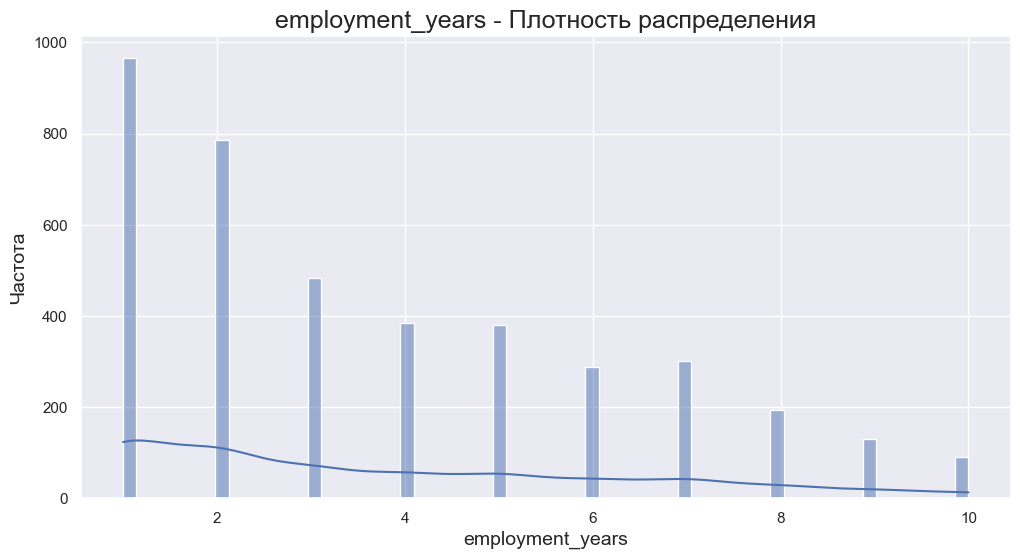

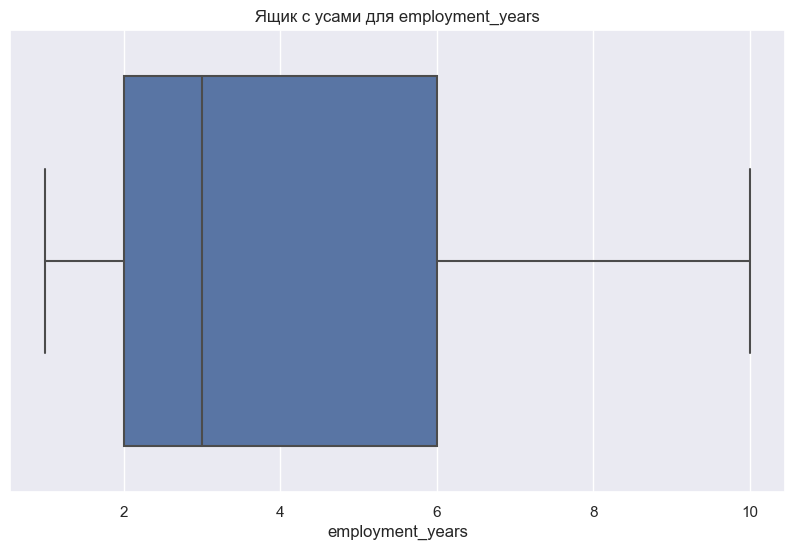

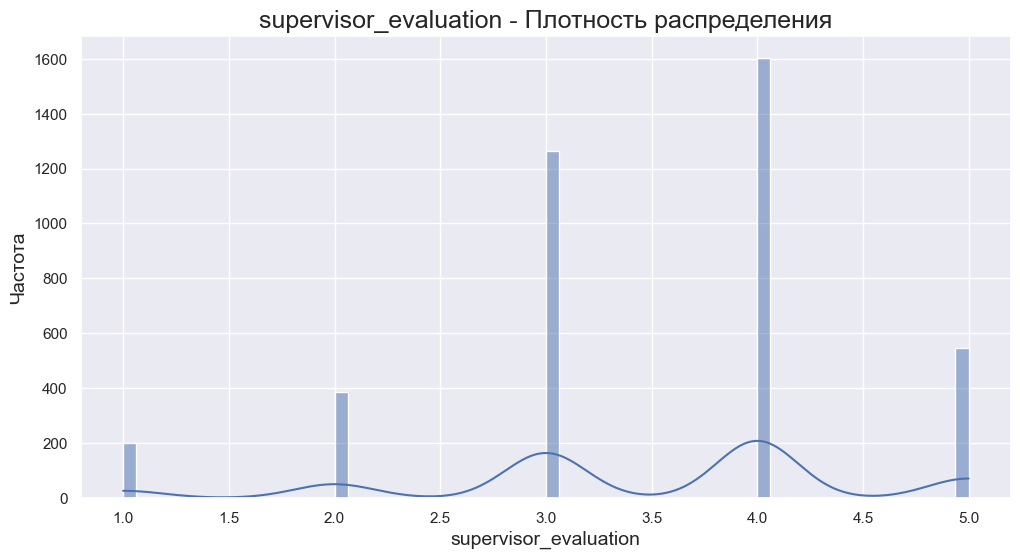

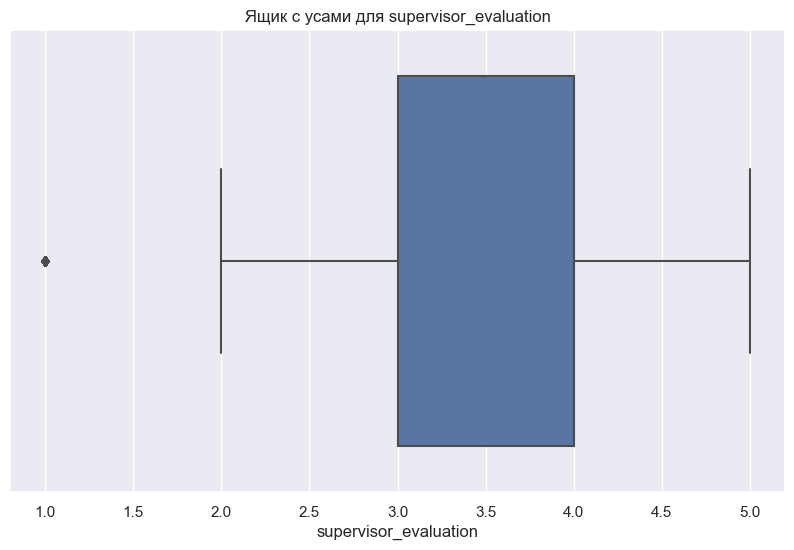

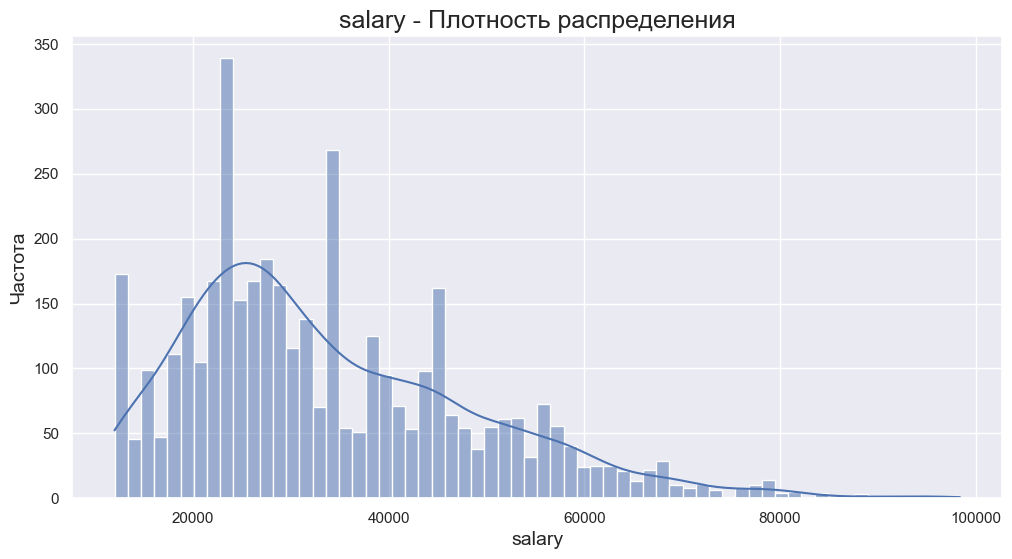

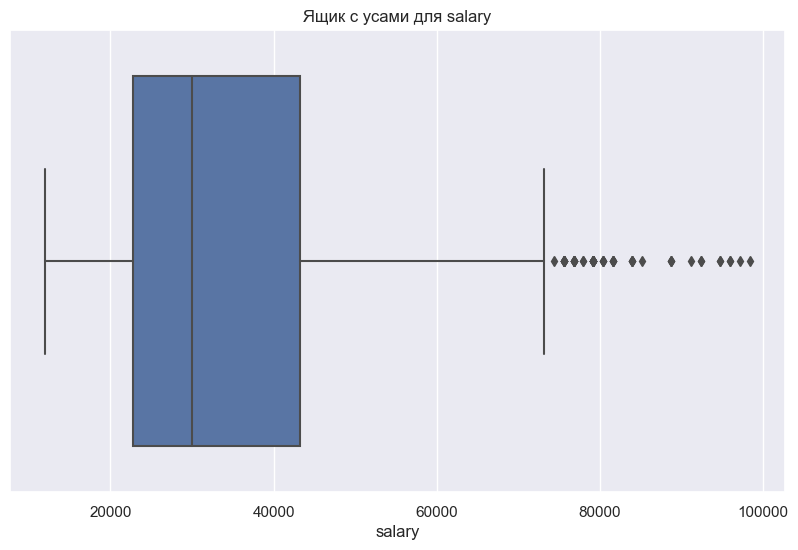

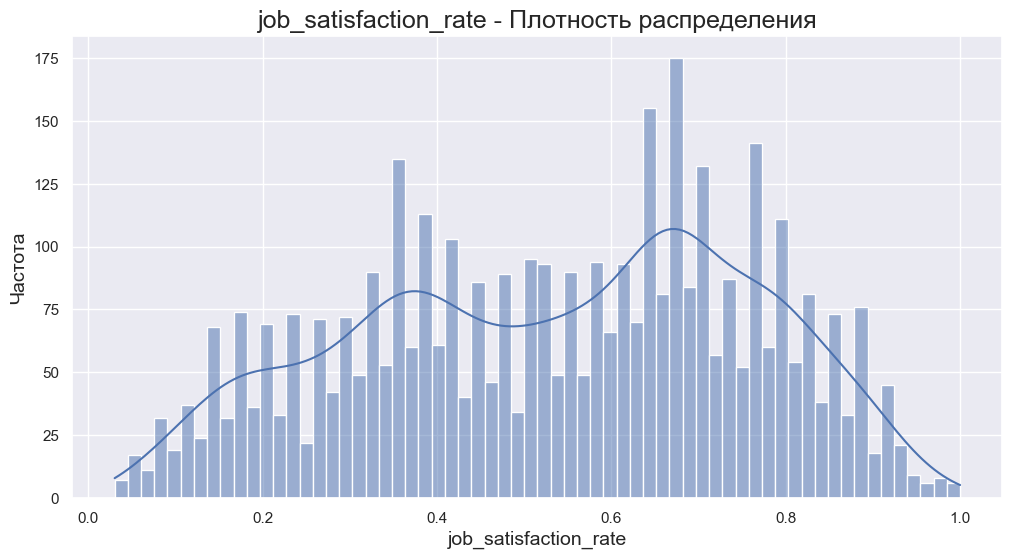

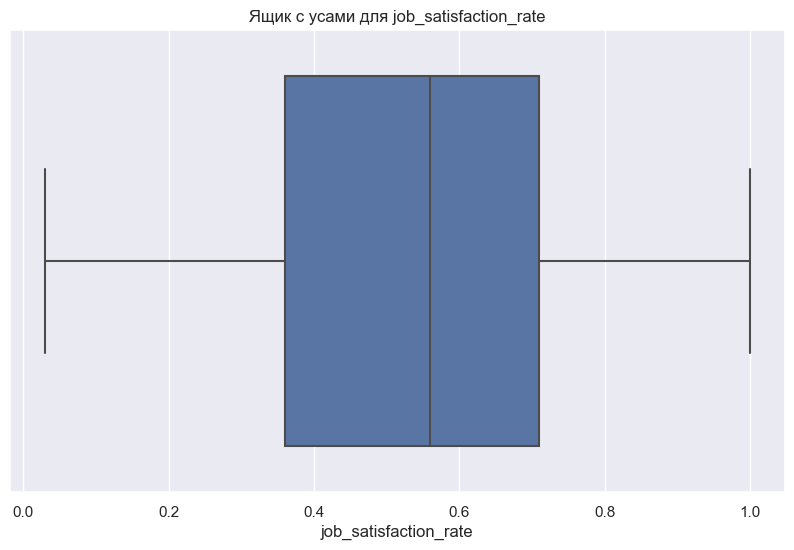

In [22]:
for num_col in num_col_train_job:
    create_histogram(df_train_job_satisfaction_rate, num_col)
    create_boxplot(df_train_job_satisfaction_rate, num_col)

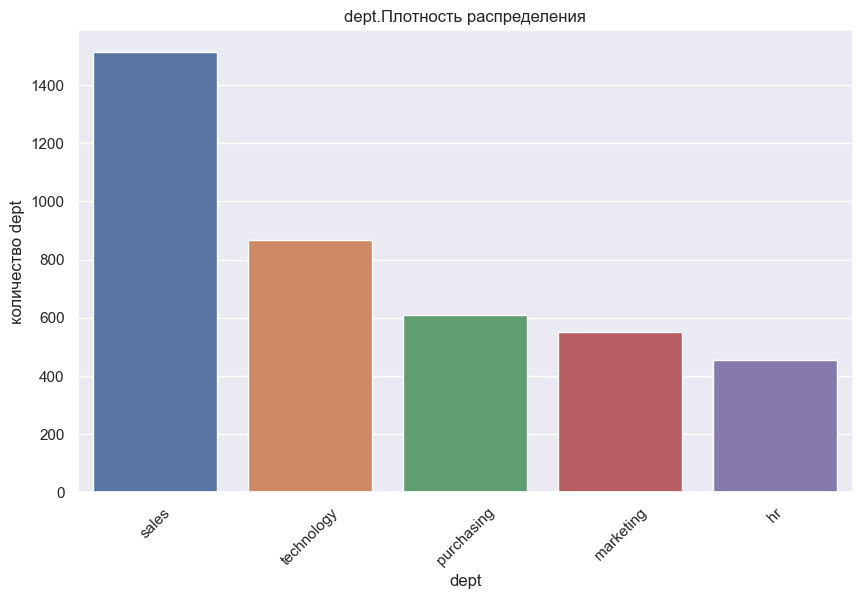

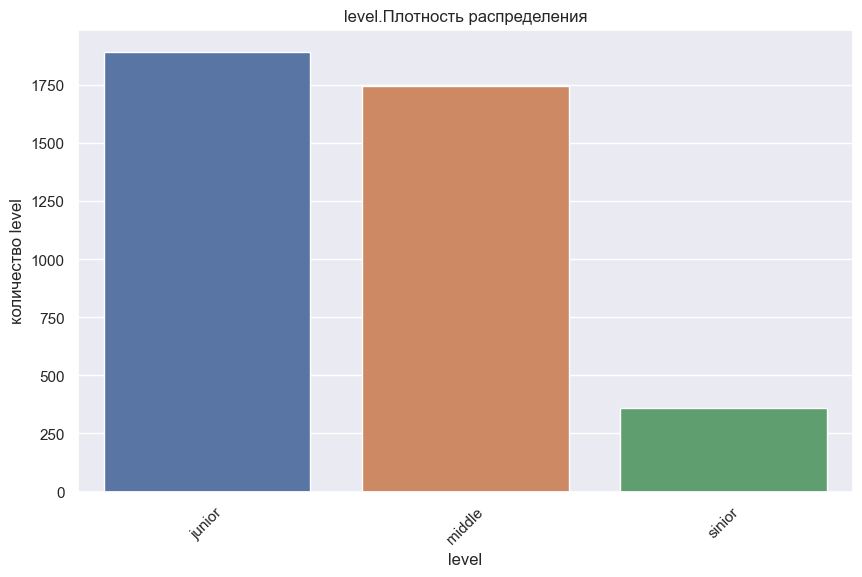

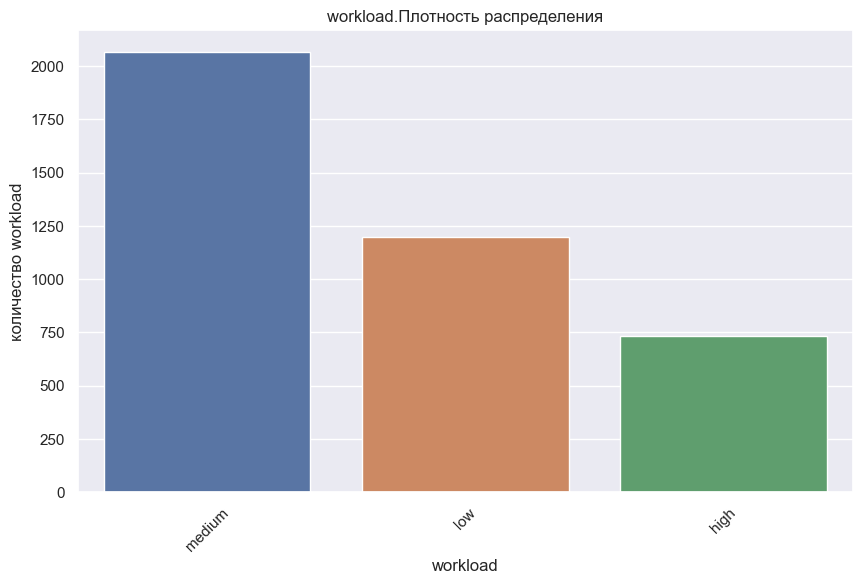

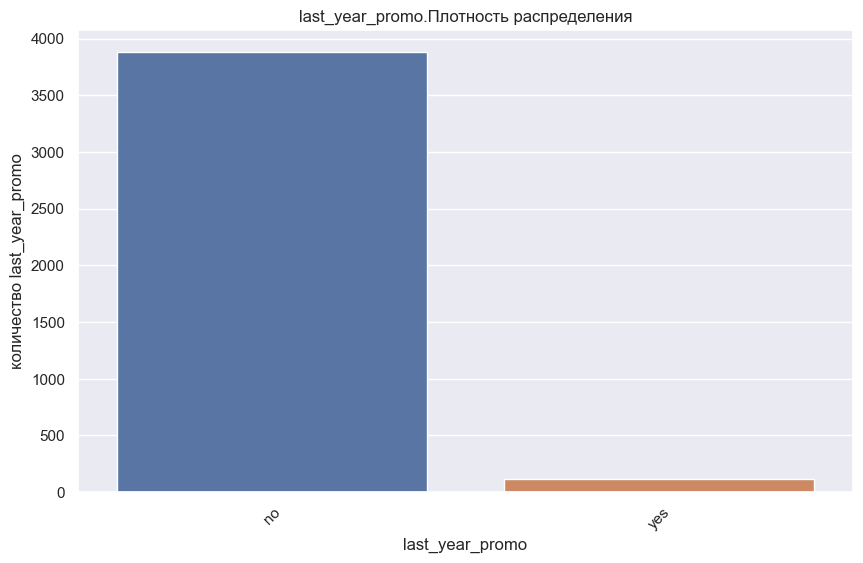

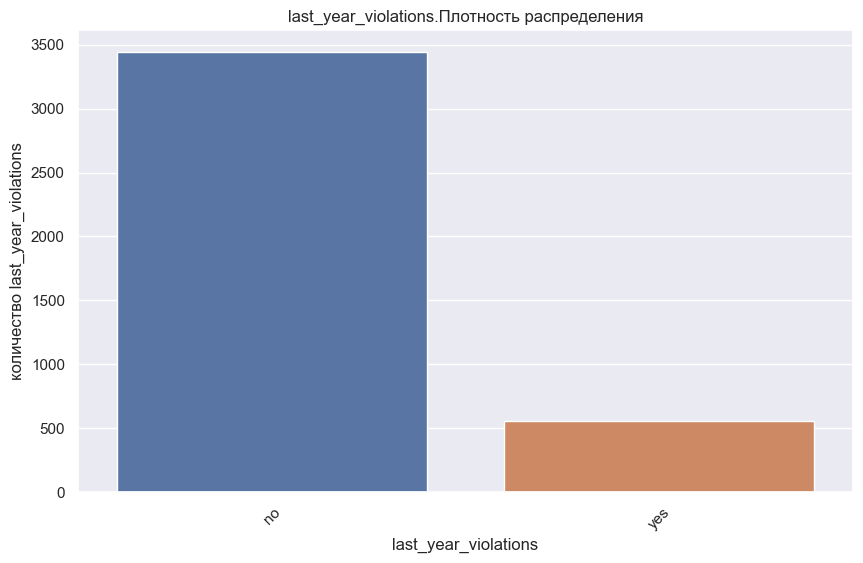

In [23]:
for cat_col in cat_col_train_job:
    create_barplot(df_train_job_satisfaction_rate, cat_col)

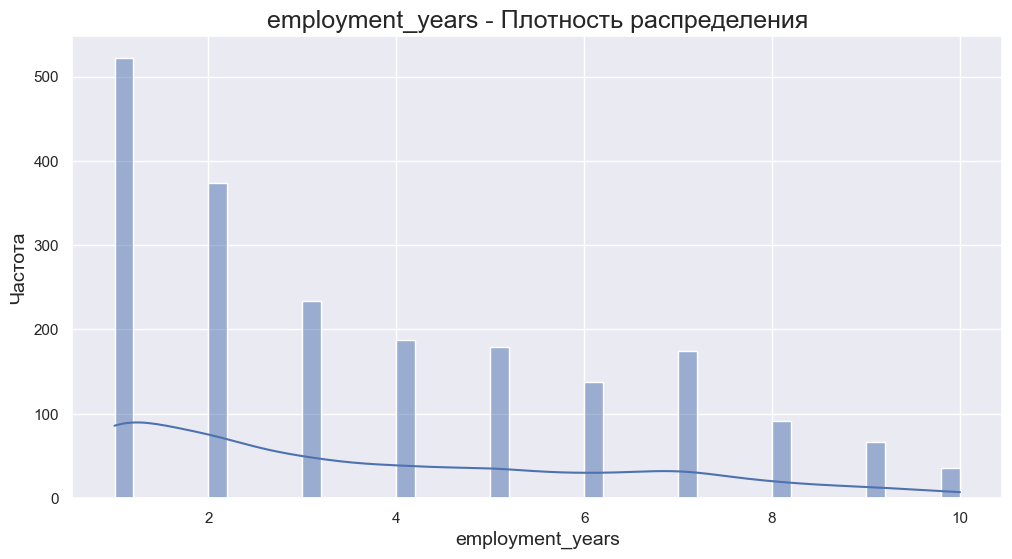

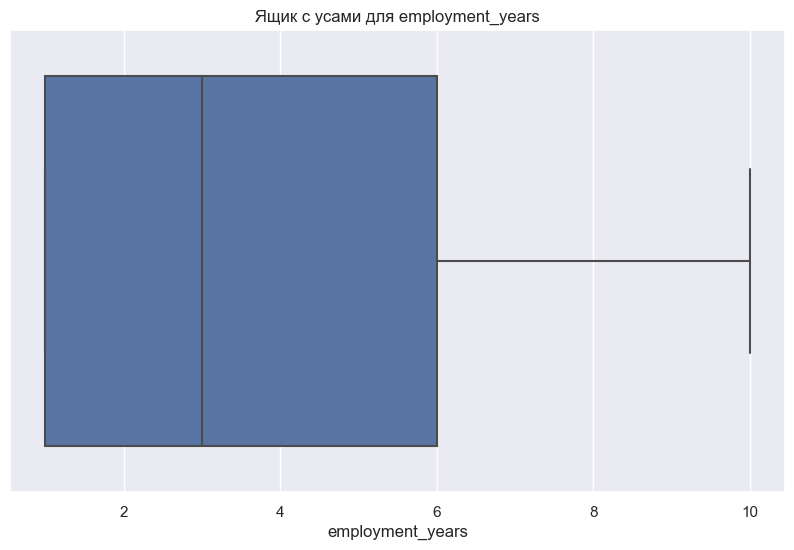

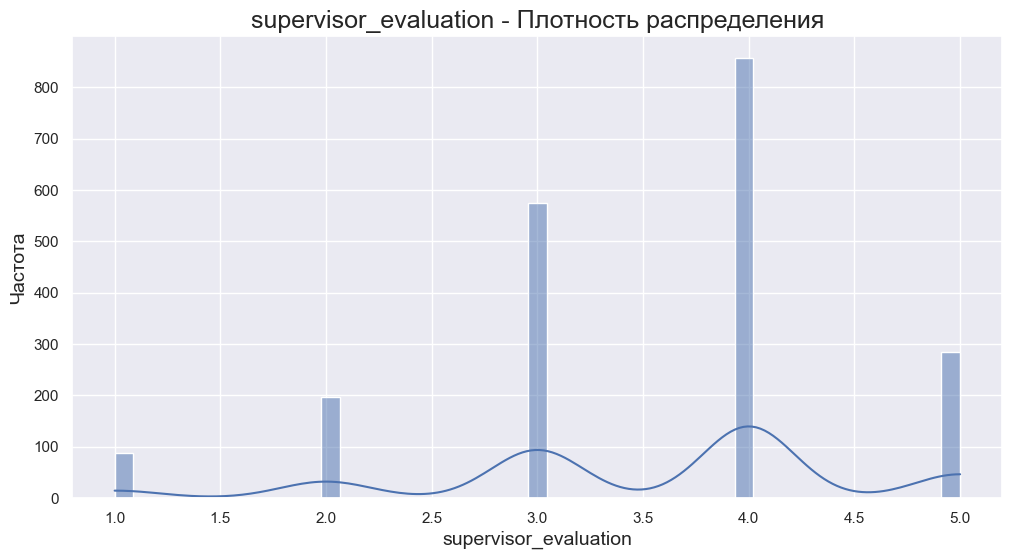

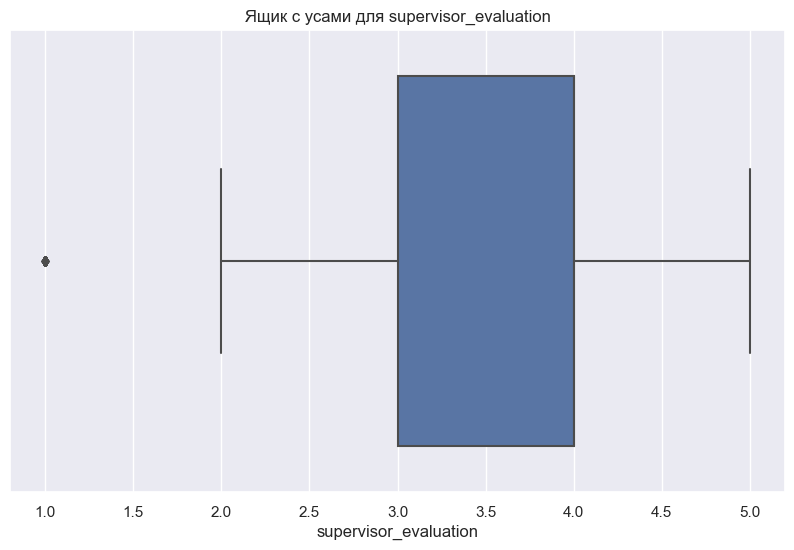

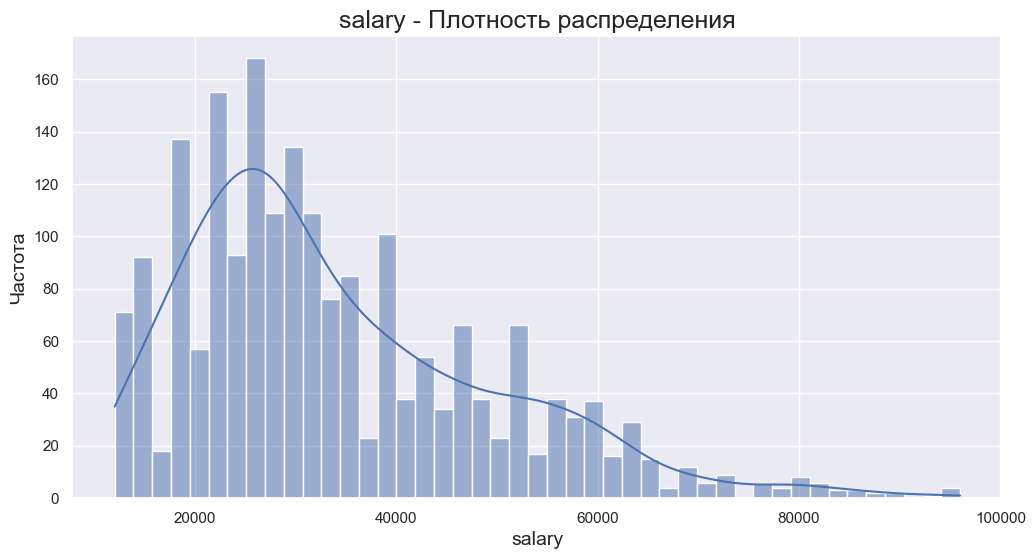

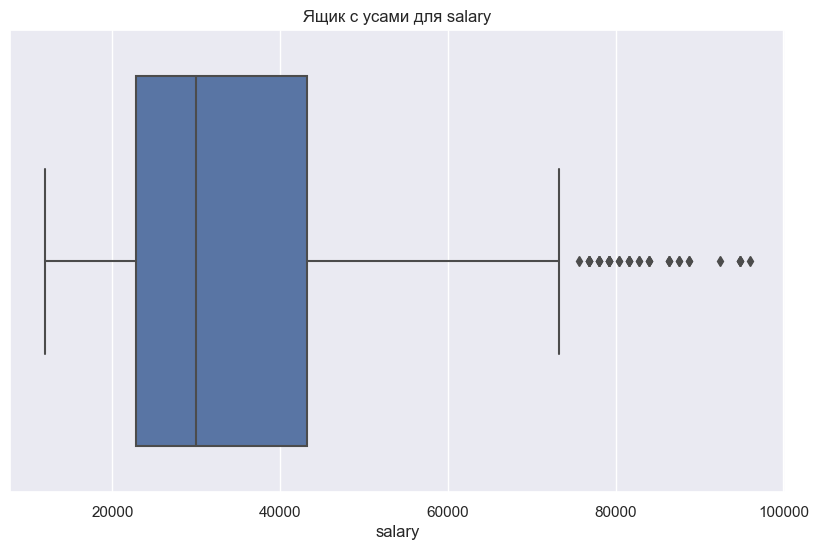

In [24]:
for num_col in num_col_test_features:
    create_histogram(df_test_features, num_col)
    create_boxplot(df_test_features, num_col)

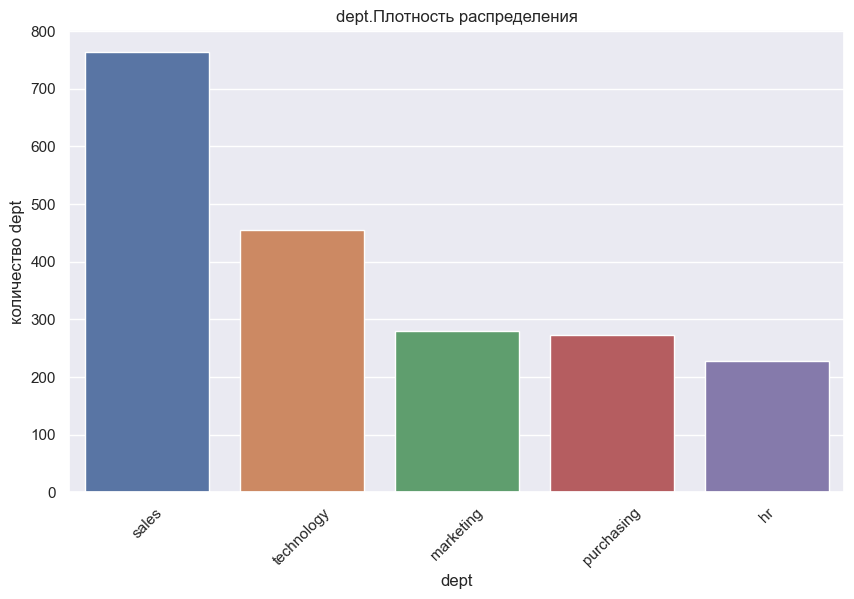

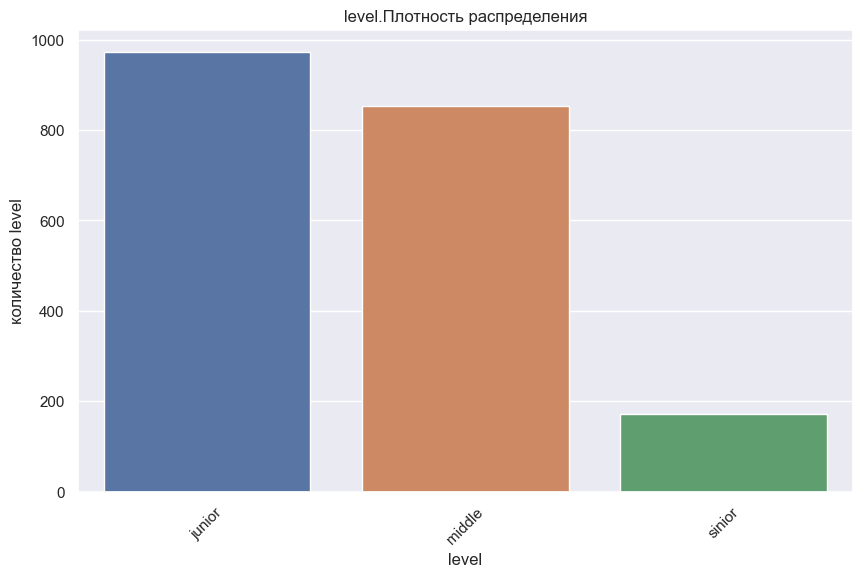

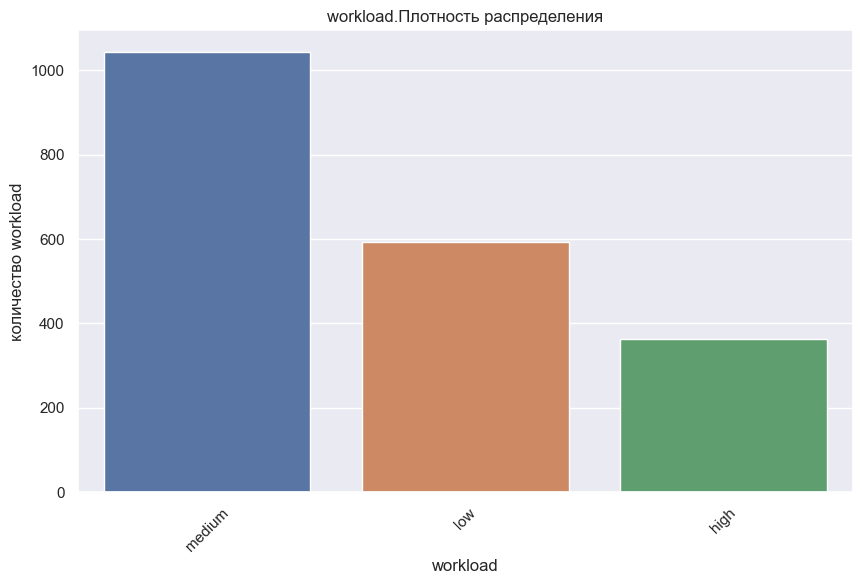

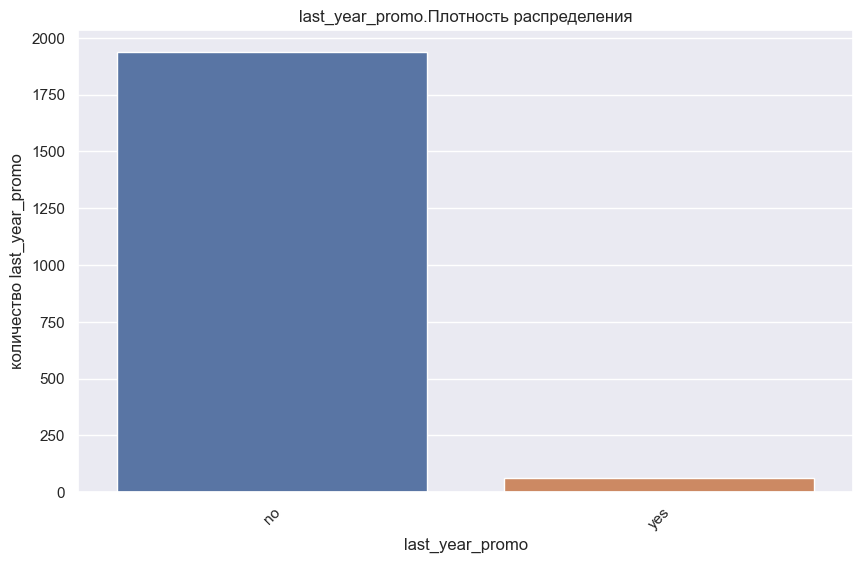

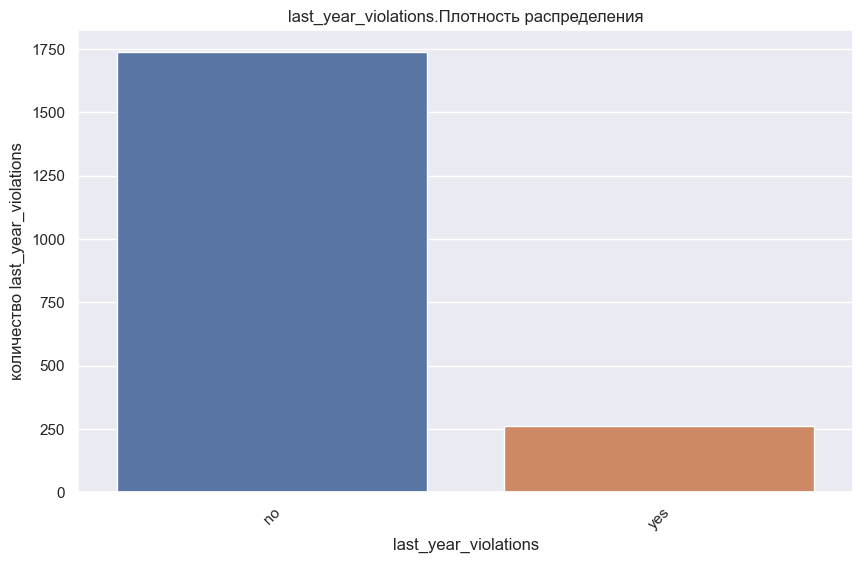

In [25]:
for cat_col in cat_col_train_job:
    create_barplot(df_test_features, cat_col)

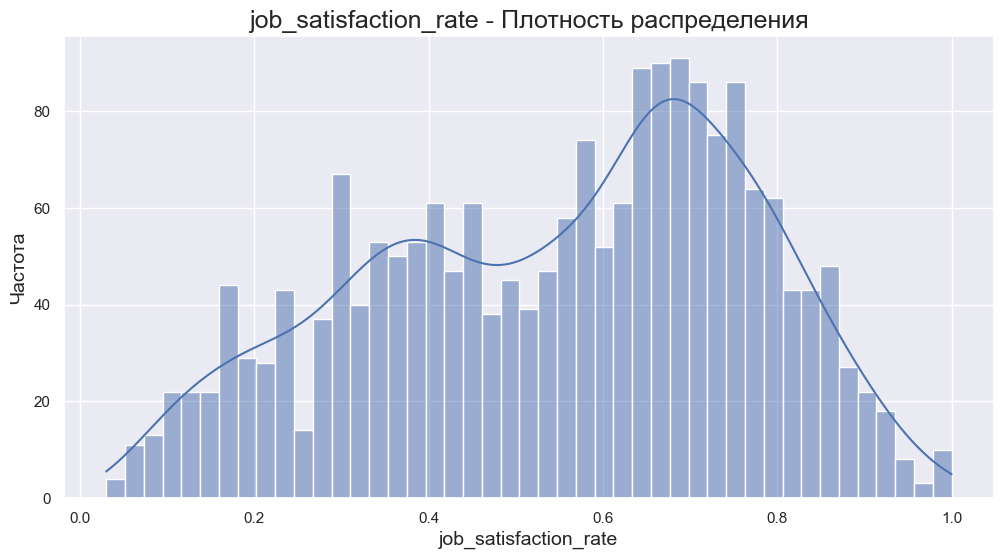

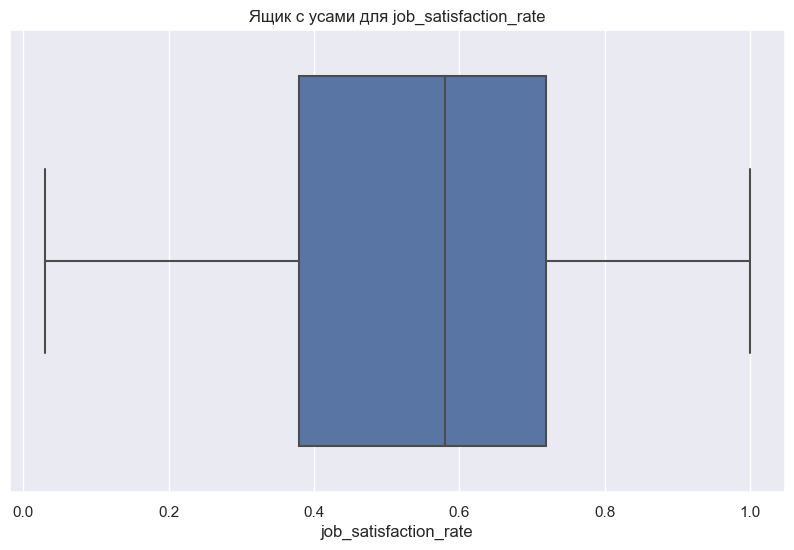

In [26]:
create_histogram(df_test_target_job_satisfaction_rate, 
                 'job_satisfaction_rate')

create_boxplot(df_test_target_job_satisfaction_rate, 
                 'job_satisfaction_rate')

In [27]:
df_train_job_satisfaction_rate = \
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate['supervisor_evaluation'] >= 2]
df_train_job_satisfaction_rate = \
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate['salary'] <=75_000]


# Подготовка данных

In [28]:
df_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 1 to 3998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3744 non-null   int64  
 1   dept                   3738 non-null   object 
 2   level                  3740 non-null   object 
 3   workload               3744 non-null   object 
 4   employment_years       3744 non-null   int64  
 5   last_year_promo        3744 non-null   object 
 6   last_year_violations   3744 non-null   object 
 7   supervisor_evaluation  3744 non-null   int64  
 8   salary                 3744 non-null   int64  
 9   job_satisfaction_rate  3744 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 321.8+ KB


In [29]:
ord_cols = ['level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_cols = ['dept']


In [30]:
train_features = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
train_target = df_train_job_satisfaction_rate['job_satisfaction_rate']


In [31]:
df_test_combined =df_test_features.merge(df_test_target_job_satisfaction_rate, on='id')
df_test_combined.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


In [32]:
df_test_combined.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [33]:
df_test_combined.duplicated().sum()

0

In [34]:
df_test_combined_target = df_test_combined['job_satisfaction_rate']
df_test_combined_features = df_test_combined.drop('job_satisfaction_rate', axis=1)

In [35]:
# определение пайплайнов для каждого типа обработки
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], 
                                       ['low', 'medium', 'high'], 
                                       ['нет', 'да'], 
                                       ['да', 'нет']],
                                         handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
])

numeric_pipe = Pipeline(steps=[
    ('quantile', QuantileTransformer())
])

# определение ColumnTransformer
data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', numeric_pipe, num_col_test_features)
], remainder='passthrough')

# создание основного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 30),
        'models__min_samples_split': range(1, 30),
        'models__min_samples_leaf': range(1, 30), 
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 0.2, 0.3, 0.4 ,1, 10, 15, 20], 
    },
    {
        'models': [LinearRegression()] 
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 1, 10],
    },

     {
        'models': [SVR()],
        'models__C': [1, 2, 4, 5],
        'models__kernel': ['linear']
    }
]


# определение функции SMAPE
def smape(y_true, y_pred): 
    return  200/len(y_true) * np.sum(np.abs(y_pred - y_true) / 
                                    (np.abs(y_true) + np.abs(y_pred)))

# создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    cv=10,
    scoring=make_scorer(smape, greater_is_better=False),
    n_jobs=-1,
    random_state=RANDOM_STATE)

# подгонка модели
random_search.fit(train_features, train_target)

# вывод лучшей модели и ее параметров
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(df_test_combined_features)
score=make_scorer(smape, greater_is_better=False)
print(f'Метрика SMAPE на тестовой выборке: {smape(df_test_combined_target, pred)}')


/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for t

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                               

# Задача 2

In [38]:
try:
    df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
except Exception:
    print()

In [39]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [40]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


## этап 